In [1]:
import astropy.units as u
import numpy as np
from astropy.constants import astropyconst20 as const
import matplotlib.pyplot as plt
import sys
from gammapy.astro.source import PWN, SNR, SNRTrueloveMcKee
import multiprocessing as mp
from multiprocess import Pool
from tqdm import tqdm
import time

In [2]:
# Here you should set path to [YOUR LOCAL PATH]/GAMERA/lib/
# Path to GAMERA should be set before functions from pwn_modeling are imported
sys.path.append('/Users/jakub/science/software/GAMERA/lib/')
import gappa as gp
from pwn_modeling.utils.time_development import run_particle_developemnt

In [3]:
# input params 
Esn = 1e51 * u.erg
Mej = 8 * u.M_sun
n_ism = 0.1 * u.cm**-3
p = 3
tau_sd = 500 * u.year
Edot0 = 1e40 * u.erg / u.s
v_psr = 120 * u.km / u.s
n_B = 0.001
n_E = 1-n_B
Ee_min = 511 * u.keV #100 * u.GeV #
Ee_max = 500 * u.TeV
g_e = 2
E0 = 1 * u.TeV

a = (p + 1) / (p - 1)
vt = (40 * Esn / (15 * Mej))**0.5

age = 1e5 * u.yr

distance = 1e3 # optional, in parsec. If not set or equals zero, differential
               # photon production rate instead of flux will be calculated

In [4]:
# Time axis to create lookup tables of variable environment
t = np.logspace(0, np.log10(age.to_value(u.yr)), 100) * u.yr

In [5]:
# Times where we want to calculate the particle and photon spectra
tt = np.logspace(1, np.log10(age.to_value(u.yr)), 10)

In [6]:
# Here we assume that we can parametrize the PWN development and we can just calculate the evolution of injected particles in this environment
# Until the collision of PWN with the reverse shock, it evolves without much simplification, as in the iterative model of Gelfand 2009
# But until then it just assumes the Radius to be constant..
# Even this simple model considers the luminosity of the pulsar inside! Look at the magnetic field which is 
# getting stronger even after the radius of PWN stays constant

In [7]:
snr = SNRTrueloveMcKee(m_ejecta=Mej, n_ISM=n_ism)
pwn = PWN(snr=snr, eta_e=n_E, eta_B=n_B)
pwn.pulsar.L_0 = Edot0
pwn.pulsar.n = p
pwn.pulsar.tau_0 = tau_sd

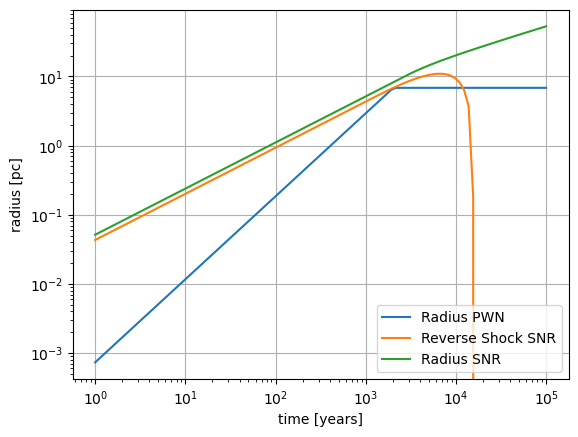

In [8]:
plt.plot(t.value, pwn.radius(t).to("pc").value, label="Radius PWN")
plt.plot(t.value, snr.radius_reverse_shock(t).to("pc").value, label="Reverse Shock SNR")
plt.plot(t.value, snr.radius(t).to("pc").value, label="Radius SNR")

plt.xlabel("time [years]")
plt.ylabel("radius [pc]")
plt.legend(loc=4)
plt.loglog()
plt.grid()
plt.show()

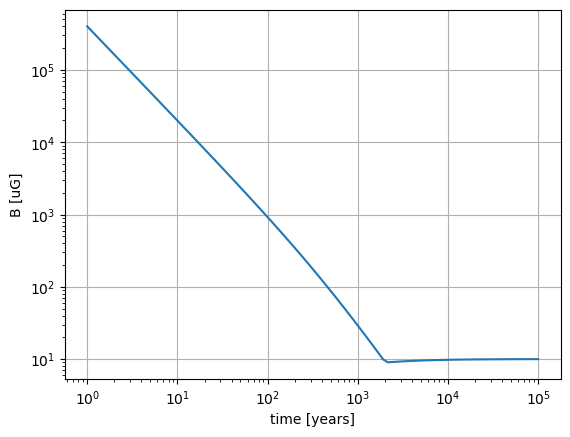

In [9]:
plt.plot(t.value, pwn.magnetic_field(t).to("G").value*1e6)
plt.xlabel("time [years]")
plt.ylabel("B [uG]")
plt.loglog()
plt.grid()
plt.show()

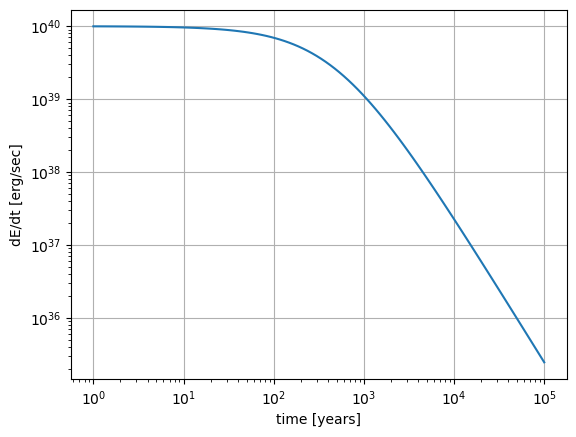

In [10]:
plt.plot(t.value, pwn.pulsar.luminosity_spindown(t).to("erg/s").value)
plt.xlabel("time [years]")
plt.ylabel("dE/dt [erg/sec]")
plt.loglog()
plt.grid()
plt.show()

In [11]:
# Initial properties of PWN
time_0 = t[0] #/2.

x = time_0 / tau_sd

if a == 2:
    eps = np.log(1 + x) / x - 1 / (x + 1)
else:
    eps = (1 + x)**(1-a) / (1 - a) - (1 + x)**(2-y) / (x * (1-a) * (2 - a)) + 1 / (x * (1-a) * (2 - a))
E_PWN_0 = eps * tau_sd * Edot0
E_PWN_e_0 = n_E * E_PWN_0
E_PWN_B_0 = n_B * E_PWN_0

# Initial particle spectrum
e_total_pl = E_PWN_e_0.to_value(u.erg) # erg

bins = 20
e = np.logspace(np.log10(Ee_min.to_value(u.TeV)), np.log10(Ee_max.to_value(u.TeV)), bins) * gp.TeV_to_erg 
power_law = (e/E0.to_value(u.erg))**-g_e

# renormalise to total energy (integrate E*dN/dE over E)
# Following Gamera tutorial
fu = gp.Utils()
power_law *= e_total_pl / fu.Integrate(list(zip(e, power_law * e)))
power_law_spectrum = np.array(list(zip(e, power_law)))

In [12]:
# Making input tuples for the main loop
inputs = []
for a in tt:
    inp = (power_law_spectrum, a, t, snr, pwn, distance)
    inputs.append(inp)

In [13]:
# Run the main loop (this may take some time to finish)

start_time = time.time()

# Number of processes/cores used
max_pool = min(len(inputs[0]), 7)

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.starmap(run_particle_developemnt,
                   inputs)
        )
    )
print("--- Execution time: %s minutes ---" % str((time.time() - start_time)/60.))

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
>> CALCULATING IC LOSS LOOKUP 
    61% done>> CALCULATING IC LOSS LOOKUP 
    61% done>> CALCULATING IC LOSS LOOKUP 
    61% done>> CALCULATING IC LOSS LOOKUP 
    61% done>> CALCULATING IC LOSS LOOKUP 
    61% done>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 


    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

** Evolving Electron Spectrum:
    0% done (Ener

100%|████████████████████████████████████████| 10/10 [00:00<00:00, 22721.04it/s]

--- Execution time: 30.82257664601008 minutes ---


Text(0.5, 1.0, 'Particle SEDs')

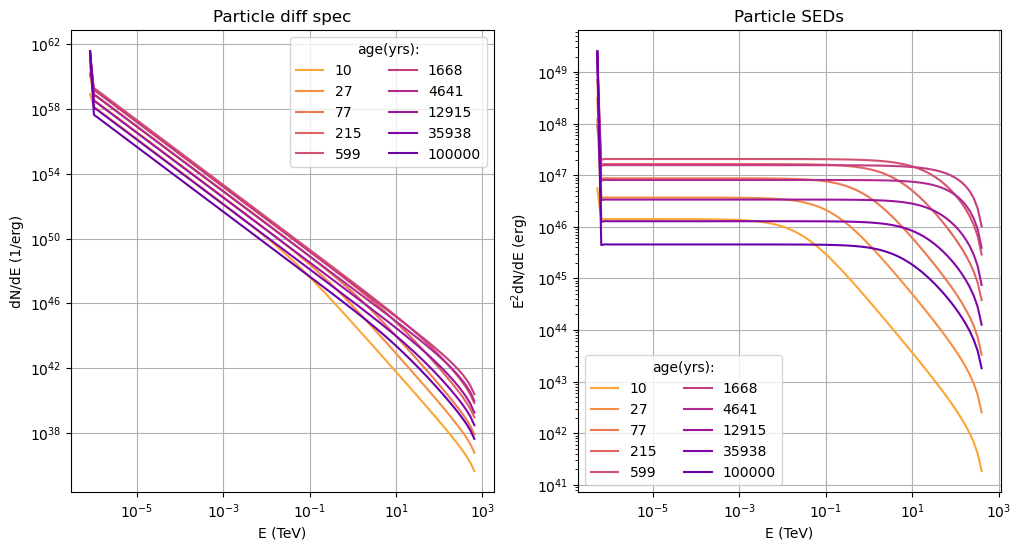

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
ax1.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(tt))))  #
ax2.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(tt))))  #

for age, results in pool_outputs:
    try:
        sp, p_sed, tot, ic, synch, total_radiated_energy = results
        ax1.loglog(sp[:,0],sp[:,1],label=str(int(age)))
        ax2.loglog(p_sed[:,0],p_sed[:,1],label=str(int(age)))
    except:
        continue

ax1.set_xlabel("E (TeV)")
ax1.set_ylabel("dN/dE (1/erg)")
ax1.grid()
ax1.legend(ncol=2,prop={'size':10},title="age(yrs):")
#ax1.set_xlim(xmin=1e-6,xmax=2e3)
#ax1.set_ylim(ymin=1e40,ymax=1e52)
ax1.set_title("Particle diff spec")

ax2.set_xlabel("E (TeV)")
ax2.set_ylabel("E"+r"$^2$"+"dN/dE (erg)")
ax2.grid()
ax2.legend(ncol=2,prop={'size':10},title="age(yrs):")
ax2.set_title("Particle SEDs")

Text(0.5, 1.0, 'Radiation SEDs')

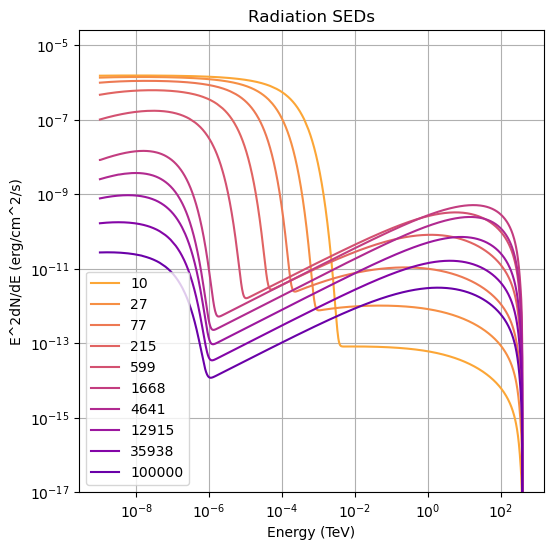

In [15]:
f, ax1 = plt.subplots(1, 1,figsize=(6,6))
ax1.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(tt))))  #

for age, results in pool_outputs:
    try:
        sp, p_sed, tot, ic, synch, total_radiated_energy = results
        ax1.loglog(tot[:,0],tot[:,1],label=str(int(age)))
    except:
        continue
        
ax1.set_xlabel("Energy (TeV)")
ax1.set_ylabel("E^2dN/dE (erg/cm^2/s)")
ax1.set_ylim(ymin=1e-17) #,ymax=1e-5)
ax1.legend()
ax1.grid()
ax1.set_title("Radiation SEDs")